In [ ]:
# Core data packages
import pandas as pd
import numpy as np
import polars as pl
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import pathlib
import warnings



# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# Set random seeds
random.seed(42)
np.random.seed(42)


About the Data:
- https://meps.ahrq.gov/mepsweb/data_stats/download_data_files.jsp
- https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_results.jsp?cboDataYear=All&cboDataTypeY=1%2CHousehold+Full+Year+File&buttonYearandDataType=Search&cboPufNumber=All&SearchTitle=Consolidated+Data


For this project, I’m working with a cleaned subset of the MEPS (Medical Expenditure Panel Survey) dataset. Specifically 2023 Full Year Consolidated Data File (PUF Number: HC251). 

MEPS is a national healthcare survey that tracks people’s demographics, insurance status, health behaviors, and medical usage and is also commonly used in fairness and healthcare modeling scenarios due to it's granularity.

In my case, I’m using MEPS because it gives me:

1. the key demographic variables I need for fairness analysis (age, sex, race/ethnicity, income, poverty level, insurance, etc.),

2. the health-status variables my model actually uses to make predictions, and enough variation across groups to see where bias shows up.

My end goal in this notebook to export all of this into a parquetdf_meta, which will become the backbone for both parts of my app:

1. Fairness Playground – where users change demographics and see how the prediction shifts.

2. Name Bias Lab – where the health profile stays constant but the first name changes.

The first goal of this project is to train a predictive model that will power the Fairness Playground.

Based on the literature I reviewed which include recent work showing strong performance of boosting methods on structured healthcare data, gradient-boosting models tend to outperform more traditional approaches for this kind of problem. They capture non-linear relationships, handle mixed data types, and generally require very little feature engineering.
(Example reference: ScienceDirect, “Tabular Data Healthcare Prediction Using Gradient Boosting Methods,” 2025)
- https://www.sciencedirect.com/science/article/pii/S2588914125000140

Because of that, I’m using two boosting models:

1. LightGBM
2. XGBoost

Both are fast, stable, and well-suited for tabular datasets like MEPS. They also work seamlessly with SHAP, which matters because the Fairness Playground relies on real-time model explanations whenever users change input values.

The better models will form the backbone of the prediction engine I will throughout the fairness module.

In [59]:
# Loading data

data_path = "./data/meps_2023/"
main_df = "h251.xlsx"

# reading as polars for speed
df_pl_raw = pl.read_excel(f"{data_path}{main_df}")

MEPS has hundreds of fields, but for the fairness playground I only keep the variables that matter most for understanding differences in healthcare predictions. These include core demographics (age, sex, race, ethnicity), socioeconomic indicators (income, education, poverty level), and basic access-to-care variables like insurance coverage. According to the MEPS documentation, these are the primary factors that shape both healthcare utilization and disparities across groups, so they’re essential for fairness analysis.

I also keep a small set of high-level health status and utilization variables — things like self-rated health, chronic condition flags, and counts of visits or expenditures. These are standard MEPS indicators used in most prediction studies, and they give the model enough signal to make meaningful predictions without going into overly detailed or sensitive medical fields. Keeping this narrowed, intentional subset helps the model stay interpretable and allows the fairness playground to compare predictions across groups in a controlled, transparent way.

In [3]:
# Mapping MEPS raw variable names to cleaner names, grouped logically

rename_map = {
    # Demographics
    "DUPERSID": "person_id",
    "AGELAST": "age",
    "SEX": "sex",
    "RACEV1X": "race_simple",
    "RACETHX": "race_ethnicity",
    "HISPANX": "hispanic",
    "BORNUSA": "born_in_usa",
    "YRSINUS": "years_in_us",
    # Socioeconomic indicators
    "EDUCYR": "education_years",
    "FAMINC23": "family_income",
    "POVCAT23": "poverty_category",
    "REGION23": "region",
    # Insurance and access to care
    "INSCOV23": "insurance_coverage",
    "INSURC23": "insurance_category",
    # Self-reported health
    "ADSMOK42": "smoker",
    # Chronic conditions
    "HIBPDX": "hypertension_dx",
    "CHDDX": "coronary_hd_dx",
    "ASTHDX": "asthma_dx",
    "DIABDX_M18": "diabetes_dx",
    # Healthcare utilization
    "IPTEXP23": "inpatient_expenditures",
}

In [4]:
# Use the rename_map keys as keep_cols so nothing gets truncated
cols_to_keep = list(rename_map.keys())
df_pl = df_pl_raw.select(cols_to_keep).rename(rename_map)

In [5]:
# converting to pandas df
df_pd = df_pl.to_pandas()

print(df_pd.shape)

(18919, 20)


In [6]:
display(df_pd.head())

,person_id,age,sex,race_simple,race_ethnicity,hispanic,born_in_usa,years_in_us,education_years,family_income,poverty_category,region,insurance_coverage,insurance_category,smoker,hypertension_dx,coronary_hd_dx,asthma_dx,diabetes_dx,inpatient_expenditures
0,2790002101,58,2,2,3,2,1,-1,17,130700,5,2,1,1,2,2,2,2,1,0
1,2790002102,27,1,2,3,2,1,-1,12,130700,5,2,1,1,-1,2,2,1,2,0
2,2790004101,49,2,1,2,2,1,-1,17,87000,5,2,1,1,2,2,2,2,2,0
3,2790006101,75,2,1,2,2,1,-1,12,38000,4,2,2,4,1,1,2,2,1,0
4,2790006102,23,1,1,2,2,1,-1,11,38000,4,2,2,2,-1,2,2,2,2,0


### Data Cleaning

##### Handling special codes
MEPS uses special negative values such as –1 (“inapplicable”), –7 (“refused”), –8 (“don’t know”), and –9 (“not ascertained”) to indicate different types of missing data. These aren’t real values, and keeping them would distort both the summary statistics and the model training. For example, the model could mistakenly treat “–8 outpatient visits” or “–9 total expenditures” as meaningful numbers, even though they don’t represent actual behavior. To avoid that, I am going to replace these with 'NAN' before any analysis so they don't show up as fake values or categories.


#### Defining target variable
For the prediction target, I define a binary variable **`hospitalized`** based on inpatient expenditures: if a person has any positive inpatient spending, I treat that as evidence of at least one hospitalization in the year. To avoid data leakage, I drop the raw inpatient expenditure field from the features after using it to construct the label.


In [7]:
# handling MEPS special codes for numeric columns
#    (-1, -7, -8, -9, -15 --> NaN)

SPECIAL_CODES = [-1, -7, -8, -9, -15]

numeric_cols = [
    "age",
    "education_years",
    "family_income",
    "years_in_us",
    "inpatient_expenditures",
]

df_pd[numeric_cols] = df_pd[numeric_cols].replace(SPECIAL_CODES, pd.NA)

In [8]:
# Quick sanity check
print(df_pd[numeric_cols].describe().T)

                          count          mean           std    min      25%  \
age                     18919.0     43.716581     23.939550    0.0     23.0   
family_income           18919.0  98815.895555  91575.419638 -230.0  35000.0   
inpatient_expenditures  18919.0   1830.599397  11540.246170    0.0      0.0   

                            50%       75%       max  
age                        45.0      64.0      85.0  
family_income           72800.0  137484.0  747346.0  
inpatient_expenditures      0.0       0.0  458360.0  


In [9]:
# Handling special codes for categorical columns as well
SPECIAL_CODES = [-1, -7, -8, -9, -15]

categorical_cols = [
    "sex",
    "race_simple",
    "race_ethnicity",
    "hispanic",
    "poverty_category",
    "insurance_coverage",
    "insurance_category",
    "region",
    "born_in_usa",
    "smoker",
    "hypertension_dx",
    "coronary_hd_dx",
    "asthma_dx",
    "diabetes_dx",
]

# Replacing MEPS special codes with NA in categorical columns
df_pd[categorical_cols] = df_pd[categorical_cols].replace(SPECIAL_CODES, pd.NA)

In [10]:
# Quick sanity check
print(df_pd[categorical_cols].describe().T)

                      count      mean       std  min  25%  50%  75%  max
sex                 18919.0  1.523601  0.499456  1.0  1.0  2.0  2.0  2.0
race_simple         18919.0  1.547386  1.194245  1.0  1.0  1.0  2.0  6.0
race_ethnicity      18919.0  2.148052  0.959049  1.0  2.0  2.0  2.0  5.0
hispanic            18919.0  1.778635  0.415176  1.0  2.0  2.0  2.0  2.0
poverty_category    18919.0  3.708970  1.411587  1.0  3.0  4.0  5.0  5.0
insurance_coverage  18919.0  1.485068  0.622105  1.0  1.0  1.0  2.0  3.0
insurance_category  18919.0  2.276389  1.609777  1.0  1.0  2.0  3.0  8.0


In [11]:
# Converting columns to numeric
df_pd["years_in_us"] = pd.to_numeric(df_pd["years_in_us"], errors="coerce")
df_pd["education_years"] = pd.to_numeric(df_pd["education_years"], errors="coerce")

# Imputing columns with median
df_pd["years_in_us"] = df_pd["years_in_us"].fillna(df_pd["years_in_us"].median())
df_pd["education_years"] = df_pd["education_years"].fillna(
    df_pd["education_years"].median()
)

print("Numeric columns converted and imputed")
print(f"years_in_us missing: {df_pd['years_in_us'].isna().sum()}")
print(f"education_years missing: {df_pd['education_years'].isna().sum()}")

Numeric columns converted and imputed
years_in_us missing: 0
education_years missing: 0


In [12]:
# One-hot encode categorical columns
df_ohe = pd.get_dummies(df_pd, columns=categorical_cols, drop_first=False)

print(f"Shape after one-hot encoding: {df_ohe.shape}")

Shape after one-hot encoding: (18919, 52)


In [13]:
# Checking for missing target values
missing_target = df_ohe["inpatient_expenditures"].isna().sum()
print(f"Missing inpatient_expenditures: {missing_target}")

Missing inpatient_expenditures: 0


In [14]:
# Work on a copy that has valid inpatient_expenditures
df_model = df_ohe[df_ohe["inpatient_expenditures"].notna()].copy()

# Define target: hospitalized = 1 if inpatient_expenditures > 0
df_model["hospitalized"] = (df_model["inpatient_expenditures"] > 0).astype(int)

# Drop leakage features from X
leakage_cols = ["inpatient_expenditures"]
df_model = df_model.drop(columns=leakage_cols)

In [15]:
"""
Used Chatgpt-5 on 21 Nov to clean and encode the feature columns
"""

'\nUsed Chatgpt-5 on 21 Nov to clean and encode the feature columns\n'

### Quick Sanity Checks and EDA

In [16]:
print(df_model.head())

    person_id  age  years_in_us  education_years  family_income  sex_1  sex_2  \
0  2790002101   58          5.0             17.0         130700  False   True   
1  2790002102   27          5.0             12.0         130700   True  False   
2  2790004101   49          5.0             17.0          87000  False   True   
3  2790006101   75          5.0             12.0          38000  False   True   
4  2790006102   23          5.0             11.0          38000   True  False   

   race_simple_1  race_simple_2  race_simple_3  race_simple_4  race_simple_6  \
0          False           True          False          False          False   
1          False           True          False          False          False   
2           True          False          False          False          False   
3           True          False          False          False          False   
4           True          False          False          False          False   

   race_ethnicity_1  race_ethnic

In [17]:
# Checking for class imbalance
print("Class balance:")
print(df_model["hospitalized"].value_counts(normalize=True))

Class balance:
hospitalized
0    0.926265
1    0.073735
Name: proportion, dtype: float64


Only 7.37% of individuals experienced any inpatient hospitalization while 93.7% did not, so the dataset is extremely imbalanced. This makes sense because hospitalization is relatively rare.

In [18]:
# Basic info
print(df_model.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18919 entries, 0 to 18918
Data columns (total 52 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   person_id             18919 non-null  object 
 1   age                   18919 non-null  int64  
 2   years_in_us           18919 non-null  float64
 3   education_years       18919 non-null  float64
 4   family_income         18919 non-null  int64  
 5   sex_1                 18919 non-null  bool   
 6   sex_2                 18919 non-null  bool   
 7   race_simple_1         18919 non-null  bool   
 8   race_simple_2         18919 non-null  bool   
 9   race_simple_3         18919 non-null  bool   
 10  race_simple_4         18919 non-null  bool   
 11  race_simple_6         18919 non-null  bool   
 12  race_ethnicity_1      18919 non-null  bool   
 13  race_ethnicity_2      18919 non-null  bool   
 14  race_ethnicity_3      18919 non-null  bool   
 15  race_ethnicity_4   

Overall, this processed dataset currently contains 18,919 rows and 94 columns. Most of the features are one-hot encoded categorical variables stored as booleans (great for boosting methods), along with a set of numeric fields capturing age, income, visits, and expenditures. Both, `years_in_us` and `education_years` still come in as object types because MEPS encodes missing data using negative codes. I’ll convert both to numeric and impute their missing values using the median so the model receives clean, consistent inputs.

Aside from those two fields, the dataset has no remaining missing values, and all categorical variables have already been fully expanded into dummy variables. The wide structure means the model can learn group-specific patterns while still being stable for gradient boosting. Overall, once those two numeric fields are fixed and imputed, the dataset is fully ready for supervised learning.

### Splitting datasets

Splitting the dataset into training and testing sets using a stratified split. Since hospitalization is rare (~7% of cases), stratification ensures both subsets maintain the same class balance. This prevents training or evaluating on an artificially skewed distribution.

Using StratifiedKFold for cross-validation so each fold has roughly the same proportion of hospitalized vs. non-hospitalized cases. This avoids folds where the minority class is underrepresented, which can lead to unstable estimates.

In [19]:
# Keep person_id separately so we can split it alongside X and y
ids = df_model["person_id"]

# Features and target
X = df_model.drop(columns=["hospitalized"])
y = df_model["hospitalized"]

# Stratified train/test split to respect imbalance
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X,
    y,
    ids,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Split shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train balance: {y_train.value_counts(normalize=True).to_dict()}")
print(f"  y_test balance: {y_test.value_counts(normalize=True).to_dict()}")

# dropping Person_ids from X_train, X_test
X_train = X_train.drop(columns=["person_id"])
X_test = X_test.drop(columns=["person_id"])

Split shapes:
  X_train: (15135, 51)
  X_test: (3784, 51)
  y_train balance: {0: 0.9262636273538156, 1: 0.07373637264618434}
  y_test balance: {0: 0.9262684989429175, 1: 0.07373150105708245}


In [20]:
# Stratified 5-fold cross-validation to preserve class balance in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Modeling

#### 1. Lightgbm

In [21]:
# LightGBM model (tuned lightly for tabular + imbalance)
lgb_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    class_weight="balanced",
    random_state=42,
)

lgb_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lgb_model.fit(X_tr, y_tr)
    val_pred = lgb_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    lgb_cv_scores.append(auc)
    print(f"Fold {fold} ROC-AUC: {auc:.3f}")

print(f"\nMean ROC-AUC: {np.mean(lgb_cv_scores):.3f} ± {np.std(lgb_cv_scores):.3f}")

[LightGBM] [Info] Number of positive: 893, number of negative: 11215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 12108, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Fold 1 ROC-AUC: 0.750
[LightGBM] [Info] Number of positive: 893, number of negative: 11215
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 12108, number of used features: 49
[L

#### 2. XGBoost

In [22]:
# Handle class imbalance for XGBoost
pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    eval_metric="logloss",
    scale_pos_weight=pos_weight,  # imbalance handling
    random_state=42,
)

xgb_cv_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), start=1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_model.fit(X_tr, y_tr)
    val_pred = xgb_model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    xgb_cv_scores.append(auc)
    print(f"Fold {fold} ROC-AUC: {auc:.3f}")

print(f"\nMean ROC-AUC: {np.mean(xgb_cv_scores):.3f} ± {np.std(xgb_cv_scores):.3f}")

Fold 1 ROC-AUC: 0.731
Fold 2 ROC-AUC: 0.696
Fold 3 ROC-AUC: 0.734
Fold 4 ROC-AUC: 0.719
Fold 5 ROC-AUC: 0.720

Mean ROC-AUC: 0.720 ± 0.013


In [23]:
print("MODEL COMPARISON")
print(
    f"LightGBM Mean ROC-AUC: {np.mean(lgb_cv_scores):.3f} ± {np.std(lgb_cv_scores):.3f}"
)
print(
    f"XGBoost Mean ROC-AUC:  {np.mean(xgb_cv_scores):.3f} ± {np.std(xgb_cv_scores):.3f}"
)

MODEL COMPARISON
LightGBM Mean ROC-AUC: 0.740 ± 0.008
XGBoost Mean ROC-AUC:  0.720 ± 0.013


After running stratified 5-fold cross-validation on both LightGBM and XGBoost, Lightgbm performed slightly better with an ROC-AUC of 0.740 than XGBoost (0.720).

hence, I’m choosing LightGBM as the final model. In addition to better performance, it also trains faster, has lower memory overhead, and integrates more smoothly with SHAP for real-time explainability in the Fairness Playground. 

### Training the Lightgbm on the full training set

In [24]:
# Final LightGBM model (same settings as CV)
final_lgb = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    class_weight="balanced",
    random_state=42,
)

# Train on full training data
final_lgb.fit(X_train, y_train)

print("Final model trained on full training set")

[LightGBM] [Info] Number of positive: 1116, number of negative: 14019
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 15135, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Final model trained on full training set


### Evaluate on Test Set


In [25]:
# Predict
y_proba_test = final_lgb.predict_proba(X_test)[:, 1]
y_pred_test = final_lgb.predict(X_test)

# Metrics
print("TEST SET PERFORMANCE")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_test):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_test):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_test):.3f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_test))

TEST SET PERFORMANCE
ROC-AUC: 0.736
Precision: 0.157
Recall: 0.505
F1 Score: 0.240

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      3505
           1       0.16      0.51      0.24       279

    accuracy                           0.76      3784
   macro avg       0.55      0.64      0.55      3784
weighted avg       0.89      0.76      0.81      3784

Confusion Matrix:
[[2750  755]
 [ 138  141]]


Interpreting the Model’s Test Performance

The final LightGBM model performs reasonably well on the test set after removing healthcare utilization and expenditure variables. The ROC-AUC is 0.736, which means the model is moderately good at distinguishing hospitalized from non-hospitalized individuals using only demographic, socioeconomic, insurance, and chronic condition features.

Precision for the positive class is 0.157, which reflects the rarity of hospitalization and the model’s tendency to flag more borderline cases as “high risk.” However, the recall of 0.505 shows that the model successfully identifies about half of the people who were actually hospitalized. The resulting F1-score of 0.240 indicates that the model’s balance between precision and recall is acceptable given the difficult, imbalanced nature of the task.

Looking at the confusion matrix, the model correctly identifies 141 out of 279 hospitalized individuals. It also keeps overall accuracy at 76%.

Overall, this level of performance is good enough to support explainability and fairness analysis. 
That means when I start showing SHAP explanations or let users tweak demographic attributes in the Fairness Playground, the changes in predictions will be meaningful.

## Looking at explainability

### Creating a mapping function to recode the features

In [26]:
# Base continuous features
base_label_map = {
    "age": "Age",
    "education_years": "Years of education",
    "family_income": "Family income",
    "years_in_us": "Years in U.S.",
}

# Category label dictionaries
sex_map = {1: "Male", 2: "Female"}

ins_map = {
    1: "Any private",
    2: "Public only",
    3: "Uninsured",
}

race_eth_map = {
    1: "Hispanic",
    2: "White",
    3: "Black",
    4: "Asian",
    5: "Other/multiple",
}

pov_map = {
    1: "Poor",
    2: "Low income",
    3: "Middle income",
    4: "High income",
    5: "Unclassifiable",
}

region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West",
}

# for yes/no medical dx encoded as _1, _2
binary_dx_map = {
    "hypertension_dx": {1: "Yes", 2: "No"},
    "coronary_hd_dx": {1: "Yes", 2: "No"},
    "asthma_dx": {1: "Yes", 2: "No"},
    "diabetes_dx": {1: "Yes", 2: "No"},
}

smoker_map = {
    1: "Never smoked",
    2: "Former smoker",
    3: "Current smoker"
}


def pretty_feature_name(col: str) -> str:
    """Convert raw feature name (including dummies) into readable text."""

    # Base continuous features
    if col in base_label_map:
        return base_label_map[col]

    # Sex
    if col.startswith("sex_"):
        code = int(col.split("_")[-1])
        return f"Sex: {sex_map.get(code, code)}"

    # Insurance coverage
    if col.startswith("insurance_coverage_"):
        code = int(col.split("_")[-1])
        return f"Insurance: {ins_map.get(code, code)}"

    # Race / ethnicity
    if col.startswith("race_ethnicity_"):
        code = int(col.split("_")[-1])
        return f"Race/ethnicity: {race_eth_map.get(code, code)}"

    # Poverty category
    if col.startswith("poverty_category_"):
        code = int(col.split("_")[-1])
        return f"Poverty: {pov_map.get(code, code)}"

    # Region
    if col.startswith("region_"):
        code = int(col.split("_")[-1])
        return f"Region: {region_map.get(code, f'Region {code}')}"  # fallback

    # Smoker
    if col.startswith("smoker_"):
        code = int(col.split("_")[-1])
        return f"Smoker: {smoker_map.get(code, f'Code {code}')}"
    
    # Chronic conditions (binary yes/no encoded as _1/_2)
    for prefix, mapping in binary_dx_map.items():
        if col.startswith(prefix + "_"):
            code = int(col.split("_")[-1])
            label = prefix.replace("_dx", "").replace("_", " ").title()
            return f"{label}: {mapping.get(code, code)}"

    # prettify by replacing underscores
    return col.replace("_", " ").title()


### Permutation Importance

In [27]:
# Compute permutation importance on the test set for the final LightGBM model

result = permutation_importance(
    final_lgb,
    X_test,
    y_test,
    n_repeats=10,        
    random_state=42,
    n_jobs=-1,           
    scoring="roc_auc",   
)

# Build a tidy DataFrame of feature importances
perm_importance_df = (
    pd.DataFrame(
        {
            "feature": X_test.columns,
            "mean_importance": result.importances_mean,
            "std_importance": result.importances_std,
        }
    )
    .sort_values("mean_importance", ascending=False)
    .reset_index(drop=True)
)

display(perm_importance_df.head(15))


,feature,mean_importance,std_importance
0,age,0.097905,0.011461
1,hypertension_dx_1,0.017736,0.003182
2,sex_1,0.016614,0.004527
3,education_years,0.014912,0.004721
4,insurance_coverage_3,0.013240,0.003923
5,family_income,0.007501,0.006377
6,diabetes_dx_2,0.004549,0.001323
7,race_ethnicity_4,0.004352,0.002968
8,asthma_dx_2,0.004040,0.001097
9,insurance_coverage_2,0.003440,0.003867


In [28]:
# Group permutation importance by parent categorical feature
grouped_importance = (
    perm_importance_df
    .assign(parent_feature=lambda df: df["feature"].str.split("_").str[0])
    .groupby("parent_feature")["mean_importance"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

(grouped_importance)


,parent_feature,mean_importance
0,age,0.097905
1,hypertension,0.017135
2,sex,0.016541
3,education,0.014912
4,insurance,0.013821
5,family,0.007501
6,asthma,0.005438
7,diabetes,0.004935
8,race,0.003417
9,years,0.002363


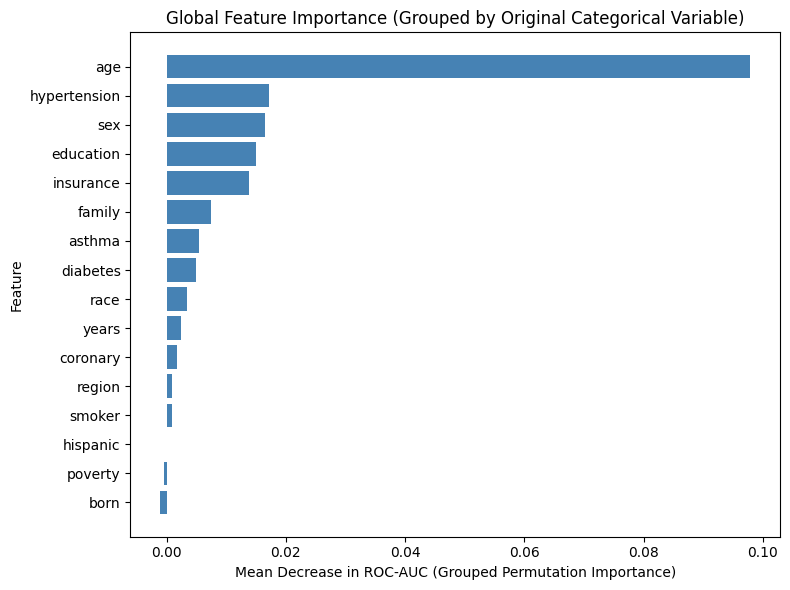

In [29]:
# Plot grouped permutation importance (top-level features)
plt.figure(figsize=(8, 6))

# Sort by importance descending for a better visual
plot_df = grouped_importance.sort_values("mean_importance", ascending=True)

plt.barh(plot_df["parent_feature"], plot_df["mean_importance"], color="steelblue")

plt.xlabel("Mean Decrease in ROC-AUC (Grouped Permutation Importance)")
plt.ylabel("Feature")
plt.title("Global Feature Importance (Grouped by Original Categorical Variable)")
plt.tight_layout()
plt.show()


Interpretation of Grouped Permutation Importance

After grouping dummy variables back into their original categories, the importance profile is easier to interpret. Age is by far the strongest predictor of hospitalization risk, which matches clinical patterns—older individuals experience more complications and chronic conditions, and are more likely to require inpatient care.

Beyond age, several moderate predictors emerge. Hypertension, sex, education, and insurance coverage show meaningful contributions, suggesting both medical risk factors and structural determinants of health influence hospitalization. Conditions like asthma and diabetes also play a role, though their effects are smaller. Socioeconomic factors such as family income, race, years in the U.S., and smoking status contribute weakly but still provide some signal.

A few predictors show negligible or slightly negative importance (e.g., poverty or being born in the U.S.), meaning shuffling those features doesn't change model performance—they carry little predictive value in this dataset.

### Global SHAP values

In [30]:
# Create SHAP explainer
explainer = shap.TreeExplainer(final_lgb)

# Sample test data (max 2000 rows)
max_rows = 2000
if len(X_test) > max_rows:
    X_shap = X_test.sample(max_rows, random_state=42)
else:
    X_shap = X_test.copy()

# Get SHAP values for positive class
shap_values_raw = explainer.shap_values(X_shap)
if isinstance(shap_values_raw, (list, tuple)):
    shap_values = shap_values_raw[1]
else:
    shap_values = shap_values_raw

# SHAP values → DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_shap.columns)

# Mean absolute SHAP per dummy feature
mean_abs_shap = shap_df.abs().mean().reset_index()
mean_abs_shap.columns = ["feature", "mean_abs_shap"]

# Extract main feature name (before underscore)
mean_abs_shap["parent_feature"] = mean_abs_shap["feature"].apply(
    lambda x: x.split("_")[0]
)

# Group by parent feature
grouped_shap = (
    mean_abs_shap.groupby("parent_feature")["mean_abs_shap"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

print(grouped_shap)


   parent_feature  mean_abs_shap
0             age       0.656572
1       insurance       0.452944
2          region       0.445760
3       education       0.315951
4            race       0.314197
5    hypertension       0.257121
6          family       0.221812
7             sex       0.203798
8          smoker       0.125992
9        diabetes       0.097249
10       coronary       0.084508
11        poverty       0.066167
12         asthma       0.059649
13           born       0.039811
14          years       0.019928
15       hispanic       0.002666


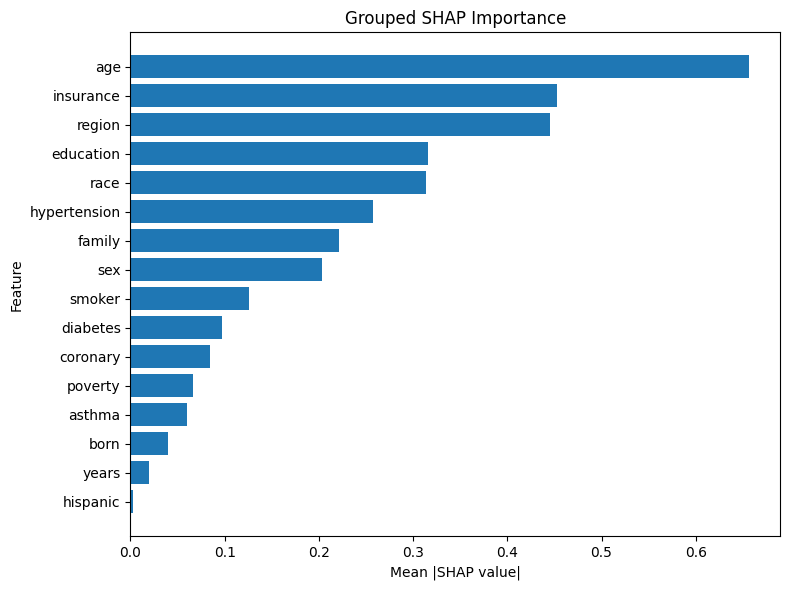

In [31]:
# Plot grouped SHAP importance
plt.figure(figsize=(8, 6))

plot_df = grouped_shap.sort_values("mean_abs_shap", ascending=True)

plt.barh(plot_df["parent_feature"], plot_df["mean_abs_shap"])
plt.xlabel("Mean |SHAP value|")
plt.ylabel("Feature")
plt.title("Grouped SHAP Importance")
plt.tight_layout()
plt.show()


The grouped SHAP plot makes it clear that age is the strongest driver of hospitalization risk in my model, which is exactly what I would expect from real-world patterns. This also matches what I saw in the permutation importance results where age dominated there as well. After age, features like insurance coverage, geographic region, education, and race show meaningful influence. These aren’t medical variables, but they capture structural and socioeconomic differences that shape who is more likely to end up hospitalized. It’s reassuring that both SHAP and permutation importance point to the same overall story.

Chronic conditions such as hypertension, diabetes, asthma, and coronary disease land in the middle of the ranking, which makes sense: they matter, but not as strongly as age or access-related variables. On the other end, things like poverty status, smoking, being born in the U.S., and years lived in the U.S. have much smaller impacts. Overall, the global SHAP results line up well with permutation importance and suggest that the model is relying on reasonable, interpretable signals rather than noisy or proxy-driven shortcuts.

### Local SHAP

After looking at global feature importance, examining one random individual who was hospitalized and one who was not, to analyze what contributed to their predictions.

In [32]:
# picking a random test example of a person who was hospitalized and a random non-hospitalized person
hospitalized_idx = y_test[y_test == 1].index
not_hospitalized_idx = y_test[y_test == 0].index

print(len(hospitalized_idx))
print(len(not_hospitalized_idx))

# Pick one random hospitalized and non-hospitalized example
i_hosp = hospitalized_idx[0]
i_non_hosp = not_hospitalized_idx[0]

x_hosp = X_test.loc[[i_hosp]]
x_non_hosp = X_test.loc[[i_non_hosp]]


279
3505


In [33]:
def plot_shap_waterfall(x_row, explainer, title="SHAP Waterfall"):
    shap_values_single = explainer.shap_values(x_row)

    # Select positive class
    if isinstance(shap_values_single, (list, tuple)):
        shap_single = shap_values_single[1][0]
        expected = explainer.expected_value[1]
    else:
        shap_single = shap_values_single[0]
        expected = explainer.expected_value

    pretty_names = [pretty_feature_name(c) for c in x_row.columns]

    # Call SHAP's waterfall_legacy (creates its own figure)
    fig = shap.plots._waterfall.waterfall_legacy(
        expected,
        shap_single,
        features=x_row.iloc[0],
        feature_names=pretty_names,
        max_display=15,
        show=False
    )

    # Add title to the existing SHAP figure
    fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()


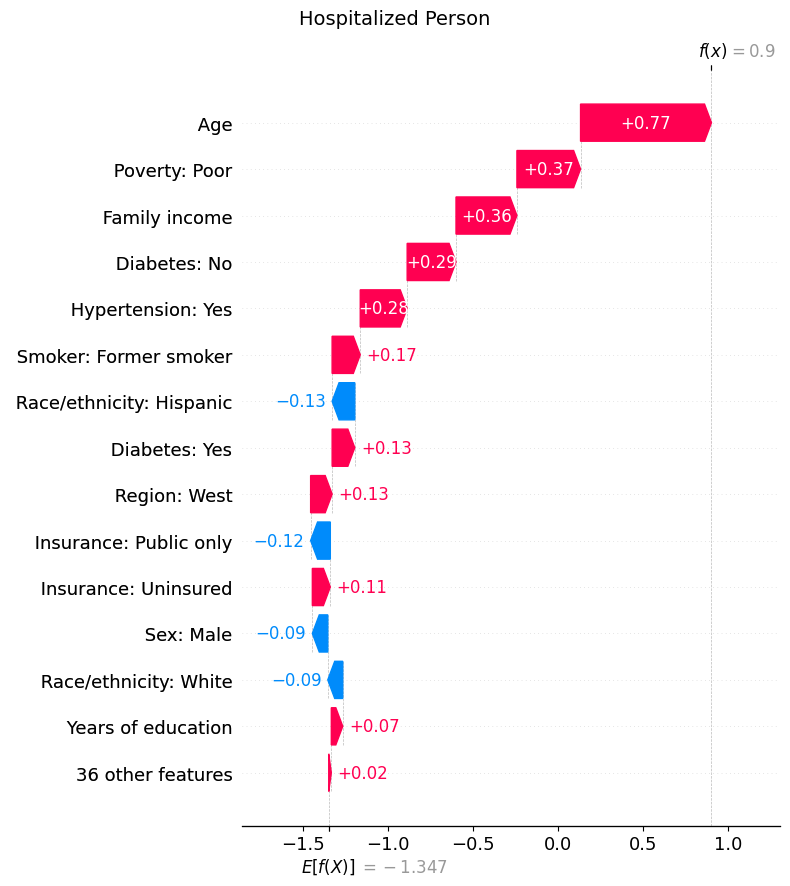

In [34]:
plot_shap_waterfall(x_hosp, explainer, title="Hospitalized Person")


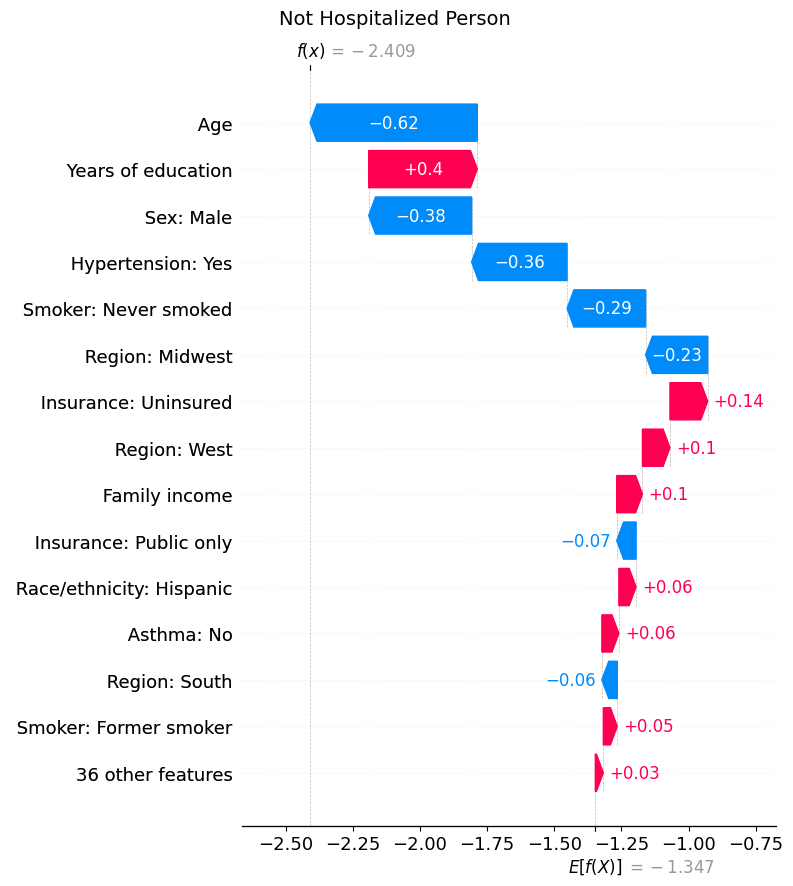

In [35]:
plot_shap_waterfall(x_non_hosp, explainer, title="Not Hospitalized Person")


Hospitalized Person

For the hospitalized person, almost everything is pushing the prediction higher. Age gives the biggest boost, and on top of that, they’re in the poorest poverty group, have higher family income within that group, and have multiple chronic conditions like diabetes and hypertension. Being a smoker also increases their risk. A couple of features pull the risk down a little (like certain race/ethnicity or insurance categories), but those effects are small. Overall, the positive pushes overwhelm the negatives, so the model ends up with a high predicted risk, which which makes sense because this person was actually hospitalized.

Not Hospitalized Person

For the not-hospitalized person, it goes in the opposite direction. Their age pulls the prediction down a lot (so they’re likely younger), and being male, not having hypertension, and not smoking all lower the risk too. There are some smaller features pushing upward, like education or certain region/insurance codes, but none of them are strong enough to outweigh the bigger downward effects. So the model ends up predicting a low risk, which lines up with the fact that this person wasn’t hospitalized.




On the whoel, these two examples match the global patterns we saw before — age, chronic conditions, insurance, and socioeconomic factors all matter. Seeing it at the individual level makes it clear that the model is using the same logic consistently, which is exactly what I need for the explainability part of the app.

### SHAP dependance plots

Next, I want to see how the model’s predicted risk changes across different values of important features. I will take the top 3 important features I identified in ungrouped permutation importance: age, hypertension present, and males. This will helps me understand the shape of the model’s behavior and look at where risk jumps, and whether certain groups are treated differently.

In [36]:
# function to make the SHAP dependence plots with recodedd labels
def shap_dependence_pretty(col, shap_values, X, color_feature=None):
    # Run SHAP dependence plot
    shap.dependence_plot(col, shap_values, X, interaction_index=color_feature, show=False)
    
    # Pretty label for the main feature
    plt.xlabel(pretty_feature_name(col))
    
    # If coloring by a feature, pretty-label that too
    if color_feature is not None:
        plt.ylabel(f"SHAP value for {pretty_feature_name(col)}")
        cbar = plt.gcf().axes[-1]  # colorbar
        cbar.set_ylabel(pretty_feature_name(color_feature))
    else:
        plt.ylabel(f"SHAP value for {pretty_feature_name(col)}")

    plt.title(f"Dependence Plot: {pretty_feature_name(col)}")
    plt.tight_layout()
    plt.show()


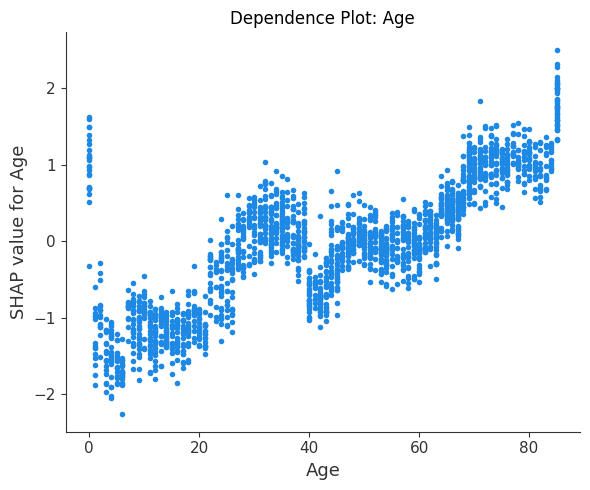

In [37]:
# SHAP Dependence for Age
shap_dependence_pretty("age", shap_values, X_shap)


The age dependence plot shows a very clear upward pattern wherein as age increases, the SHAP values steadily rise. This means that the model consistently assigns higher hospitalization risk to older individuals. Though the slope isn’t perfectly smooth, but the overall trend is obvious — risk starts to climb in middle age and keeps rising into older adulthood. This maekse sense and further reinforces the global SHAP/GI results where age was the strongest predictor.

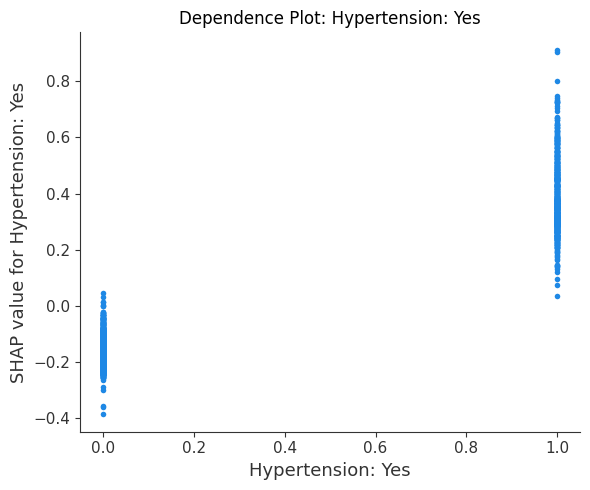

In [38]:

# SHAP Dependence for 
shap_dependence_pretty("hypertension_dx_1", shap_values, X_shap)



For hypertension, the SHAP values form two tight clusters at 0 and 1 (No vs Yes). People with Hypertension: Yes mostly receive positive SHAP values, meaning the model bumps their risk upward. People without hypertension mostly get negative SHAP values, meaning it lowers their predicted risk. There’s almost no overlap, so hypertension has a very consistent direction: it pushes risk up when present.

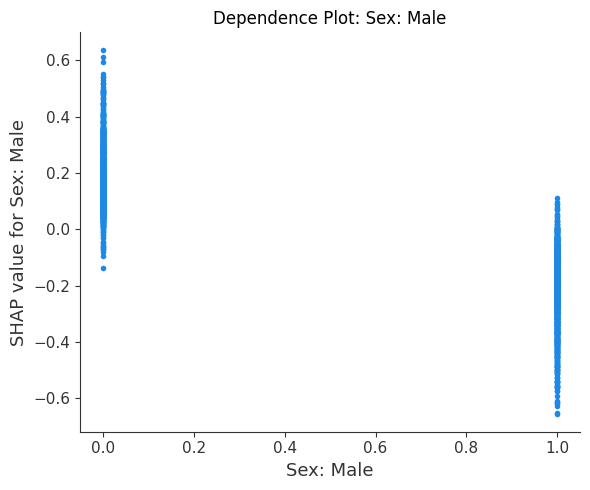

In [39]:
# SHAP Dependence for Males
shap_dependence_pretty("sex_1", shap_values, X_shap)

For sex, “Sex: Male” shows a similar two-cluster pattern like hypertension, but the effect size is smaller. When the dummy is 1 (male), the SHAP values are mostly negative or slightly negative — meaning being male tends to lower predicted hospitalization risk a bit for this model. When the value is 0 (female), the SHAP values are slightly positive, meaning female patients get a small upward adjustment. This lines up with your global SHAP bar chart where sex had a modest but non-zero effect.

### Group-level prediction averages

Now, I’m going to compute the average predicted risk across demographic groups  such as sex, race, insurance, poverty. I’m looking at average predicted risk across insurance type, sex, race/ethnicity, and poverty groups because these are the demographic and socioeconomic factors most commonly linked to unequal healthcare access and outcomes in the real world. If my model assigns noticeably higher or lower predicted hospitalization risk to certain groups, that could indicate either real clinical differences or potential fairness concerns. Checking these group averages now gives me an early sense of how the model treats different populations before I build the interactive fairness playground.

But first I need to extract a clean subset of the dataset containing only the human-readable demographic attributes plus person_id, and save it as df_meta. This makes it much easier in the fairness notebook to merge predictions back with the correct demographic information, without trying to reconstruct categories from dummy variables.

In [40]:
# creating df_meta (demographic attributes only)
meta_cols = [
    "person_id",
    "age",
    "sex",
    "race_ethnicity",
    "hispanic",
    "poverty_category",
    "insurance_coverage",
    "family_income",
]

df_meta = df_pd[meta_cols].copy()

# creating df_fairness
df_eval = pd.DataFrame({
    "person_id": ids_test,   # keep the identifier
    "y_true": y_test.values,
    "pred_prob": y_proba_test
})
df_fair = df_eval.merge(df_meta, on="person_id", how="left")


In [41]:
# Recoding the sensitive attributes
# Recode sex
def recode_sex(df):
    sex_map = {1: "Male", 2: "Female"}
    df["sex"] = df["sex"].map(sex_map)
    return df


# Recode Race/Ethnicity (RACETHX)
def recode_race_ethnicity(df):
    race_map = {
        1: "Hispanic",
        2: "White",
        3: "Black",
        4: "Asian",
        5: "Other OR Multiple",
    }
    df["race_ethnicity"] = df["race_ethnicity"].map(race_map)
    return df


# Recode Hispanic Flag (HISPANX)
def recode_hispanic(df):
    hisp_map = {1: "Hispanic", 2: "Not Hispanic"}
    df["hispanic"] = df["hispanic"].map(hisp_map)
    return df


# Poverty Category (POVCAT23)
def recode_poverty(df):
    pov_map = {
        1: "Poor",
        2: "Low income",
        3: "Middle income",
        4: "High income",
        5: "Unclassifiable",
    }
    df["poverty_category"] = df["poverty_category"].map(pov_map)
    return df


# Insurance Coverage (INSCOV23)
def recode_insurance(df):
    ins_map = {1: "Any private", 2: "Public only", 3: "Uninsured"}
    df["insurance_coverage"] = df["insurance_coverage"].map(ins_map)
    return df


# Recode Self-Rated Health (RTHLTH53)
def recode_self_rated_health(df):
    health_map = {
        1: "Excellent",
        2: "Very good",
        3: "Good",
        4: "Fair",
        5: "Poor",
    }
    df["self_rated_health"] = (
        df["self_rated_health"].round().astype("Int64").map(health_map)
    )
    return df


# Recode Self-Rated Mental Health (MNHLTH53)
def recode_self_rated_mental(df):
    mental_map = {
        1: "Excellent",
        2: "Very good",
        3: "Good",
        4: "Fair",
        5: "Poor",
    }
    df["self_rated_mental_health"] = (
        df["self_rated_mental_health"].round().astype("Int64").map(mental_map)
    )
    return df


df_fair = recode_sex(df_fair)
df_fair = recode_race_ethnicity(df_fair)
df_fair = recode_hispanic(df_fair)
df_fair = recode_poverty(df_fair)
df_fair = recode_insurance(df_fair)


display(df_fair.head())

,person_id,y_true,pred_prob,age,sex,race_ethnicity,hispanic,poverty_category,insurance_coverage,family_income
0,2795536102,0,0.082473,44,Male,White,Not Hispanic,High income,Any private,142202
1,2796668104,0,0.105641,4,Male,Hispanic,Hispanic,Poor,Public only,0
2,2815945102,0,0.067537,60,Female,Hispanic,Hispanic,High income,Uninsured,64010
3,2813232102,0,0.068694,59,Male,White,Not Hispanic,Unclassifiable,Any private,335489
4,2810968102,0,0.171902,30,Male,White,Not Hispanic,High income,Uninsured,47840


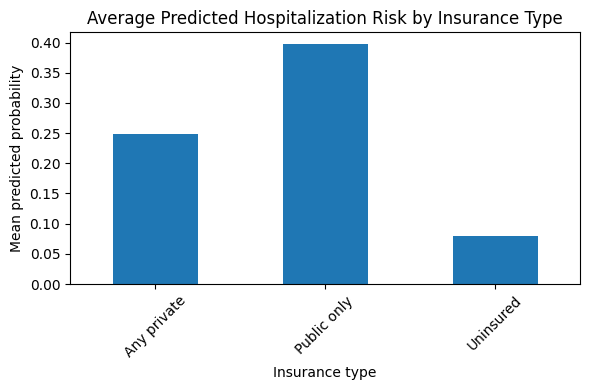

In [42]:
# 1. Average predicted risk by insurance type
df_plot = df_fair.groupby("insurance_coverage")["pred_prob"].mean()

df_plot.plot(kind="bar", figsize=(6,4))
plt.title("Average Predicted Hospitalization Risk by Insurance Type")
plt.ylabel("Mean predicted probability")
plt.xlabel("Insurance type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


People with public insurance have the highest predicted hospitalization risk, followed by those with private insurance. The uninsured group has the lowest predicted risk. This makes sense since uninsured people typically avoid or delay care, so the model learns lower hospitalization rates for them. Public insurance often captures older, disabled, or lower-income individuals who already have higher medical needs.

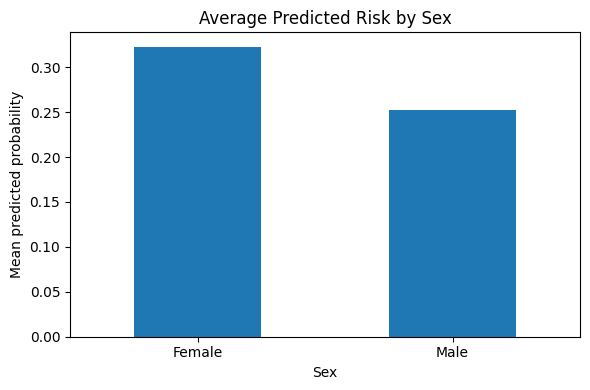

In [43]:
# 2. Average predicted risk by sex
df_plot = df_fair.groupby("sex")["pred_prob"].mean()

df_plot.plot(kind="bar", figsize=(6,4))
plt.title("Average Predicted Risk by Sex")
plt.ylabel("Mean predicted probability")
plt.xlabel("Sex")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The model predicts slightly higher risk for females than for males. This lines up with the local SHAP plot where “Sex: Male” generally pushed risk down a bit. 

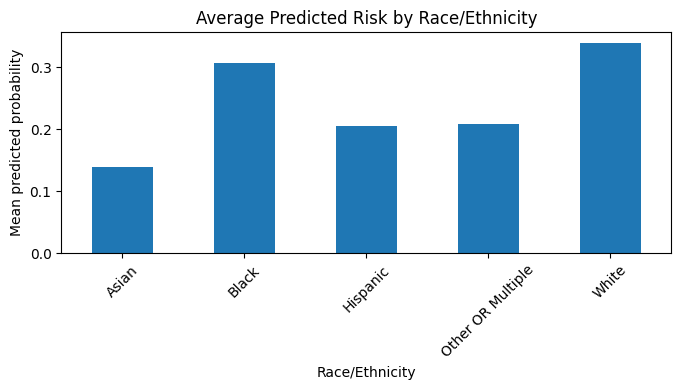

In [44]:
# 3. Average predicted risk by race/ethnicity
df_plot = df_fair.groupby("race_ethnicity")["pred_prob"].mean()

df_plot.plot(kind="bar", figsize=(7,4))
plt.title("Average Predicted Risk by Race/Ethnicity")
plt.ylabel("Mean predicted probability")
plt.xlabel("Race/Ethnicity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Predicted risk varies across race groups. White and Black individuals have higher average predicted risk than Asian, Hispanic, or Other/Mixed groups. This could be reflecting real differences in hospitalization rates in the MEPS data, but it’s also a signal I’ll want to look at more closely in the fairness playground. Importantly, these differences don’t look extreme, but they are noticeable.

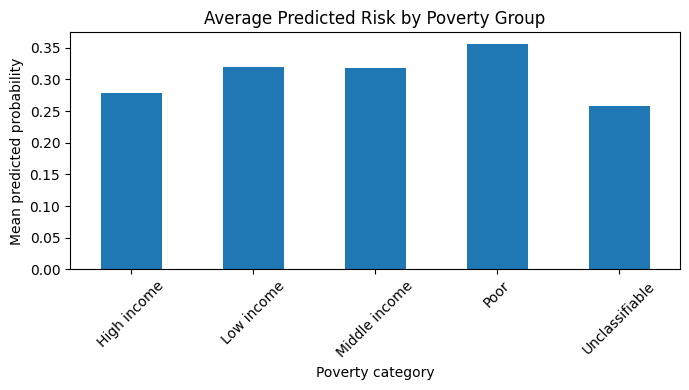

In [45]:
# 4. Average predicted risk by poverty category
df_plot = df_fair.groupby("poverty_category")["pred_prob"].mean()

df_plot.plot(kind="bar", figsize=(7,4))
plt.title("Average Predicted Risk by Poverty Group")
plt.ylabel("Mean predicted probability")
plt.xlabel("Poverty category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Predicted risk increases as you move toward poorer poverty categories, with “Poor ” showing the highest risk. Middle-income and low-income groups sit in the middle, and high-income individuals have lower predicted risk. This makes sense since socioeconomic disadvantage is associated with higher health complications and limited preventive care, while higher economic groups would tend to have higher preventive care and better lifestyle habits probably.

Overall, all four plots illustrate how the model generally behaves in a way that matches clinical and socioeconomic patterns: public insurance, female sex, certain racial groups, and higher poverty levels show higher predicted risk. The differences aren't wildly unbalanced, but there are variation across the groups.

Given that the analysis and results match what I would expect for this health data, I will now create an interface web-app for a user to see how they would compare.

Note: All the analysis is my own and I used concepts that were covered in class and assignments out here in this notebook. Hoever, I did make use of CHatgpt-5 over the last 2 weeks to write some bits of code such as the recodinf function, the k-fold validation chunk, etc.

In [46]:
# Creating a folder to store artifacts
artifacts_dir = pathlib.Path("fairness_artifacts")
artifacts_dir.mkdir(exist_ok=True)

print(f"Created artifacts directory: {artifacts_dir}")

Created artifacts directory: fairness_artifacts


In [47]:
# Saving the attribute table
df_meta.to_parquet(artifacts_dir / "df_meta.parquet", index=False)
ids_train.to_frame(name="person_id").to_parquet(
    artifacts_dir / "ids_train.parquet", index=False
)
ids_test.to_frame(name="person_id").to_parquet(
    artifacts_dir / "ids_test.parquet", index=False
)

print("Saved metadata and IDs")

Saved metadata and IDs


In [48]:
# Saving train/test feature matrices as Parquet
X_train_path = artifacts_dir / "X_train.parquet"
X_test_path = artifacts_dir / "X_test.parquet"

X_train.to_parquet(X_train_path, index=False)
X_test.to_parquet(X_test_path, index=False)

print("Saved train/test features")

Saved train/test features


In [49]:
# Saving train/test targets as Parquet
# Converting train/test targets to df to ensure clean schema
y_train_path = artifacts_dir / "y_train.parquet"
y_test_path = artifacts_dir / "y_test.parquet"

y_train.to_frame(name="hospitalized").to_parquet(y_train_path, index=False)
y_test.to_frame(name="hospitalized").to_parquet(y_test_path, index=False)

print("Saved train/test targets")

Saved train/test targets


In [50]:
# Saving the trained LightGBM model
model_path = artifacts_dir / "final_lightgbm_model.pkl"
joblib.dump(final_lgb, model_path)

print("Saved trained model")

Saved trained model


In [51]:
# Saving the SHAP explainer for use in the Fairness Playground app
results_dir = pathlib.Path("fairness_results")
results_dir.mkdir(exist_ok=True)

shap_explainer_path = results_dir / "shap_explainer.pkl"
joblib.dump(explainer, shap_explainer_path)

print(f"Saved SHAP explainer to {shap_explainer_path}")


Saved SHAP explainer to fairness_results/shap_explainer.pkl


In [ ]:
print("Saved")
print(f"Directory: {artifacts_dir}")
print("\nSaved files:")
print(f"X_train: {X_train_path}")
print(f"X_test: {X_test_path}")
print(f"y_train: {y_train_path}")
print(f"y_test: {y_test_path}")
print(f"df_meta: {artifacts_dir / 'df_meta.parquet'}")
print(f"ids_train: {artifacts_dir / 'ids_train.parquet'}")
print(f"ids_test: {artifacts_dir / 'ids_test.parquet'}")
print(f"model: {model_path}")
print(f"SHAP explainer: {shap_explainer_path}")

Saved
Directory: fairness_artifacts

Saved files:
X_train: fairness_artifacts/X_train.parquet
X_test: fairness_artifacts/X_test.parquet
y_train: fairness_artifacts/y_train.parquet
y_test: fairness_artifacts/y_test.parquet
df_meta: fairness_artifacts/df_meta.parquet
ids_train: fairness_artifacts/ids_train.parquet
ids_test: fairness_artifacts/ids_test.parquet
model: fairness_artifacts/final_lightgbm_model.pkl
SHAP explainer: fairness_results/shap_explainer.pkl
Data cleaning and modeling complete!
Ready to proceed to fairness analysis (notebook 2)
